In [1]:
%pylab inline
%matplotlib inline

import sys
import os
import pickle


sys.path.append("/Users/Bya/git/predictEPL/config/")
sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/WebScrapping/")


import paths
import names
import tokenizer
import useful_methods
import my_plot
import scrap_espn_gamecast
import espn_urls

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Game Infos
os.chdir(paths.READ_PATH_GAME_INFO)
dfGameInfos = useful_methods.csv_dic_df('game_infos.csv')

# Convert number strings to integers
dfGameInfos['GW'] = [int(GW) for GW in dfGameInfos['GW']]
dfGameInfos['score_ht_home'] = [int(number) for number in dfGameInfos['score_ht_home']]
dfGameInfos['score_ht_away'] = [int(number) for number in dfGameInfos['score_ht_away']]
dfGameInfos['score_ft_home'] = [int(number) for number in dfGameInfos['score_ft_home']]
dfGameInfos['score_ft_away'] = [int(number) for number in dfGameInfos['score_ft_away']]

dfGameInfos.head()

,GW,away_team,date,home_team,score_ft_away,score_ft_home,score_ht_away,score_ht_home,time
0,1,Tottenham,Sat. 8 Aug.,United,0,1,0,1,11:45
1,1,Watford,Sat. 8 Aug.,Everton,2,2,1,0,14:00
2,1,Sunderland,Sat. 8 Aug.,Leicester,2,4,0,3,14:00
3,1,Crystal,Sat. 8 Aug.,Norwich,3,1,1,0,14:00
4,1,Villa,Sat. 8 Aug.,Bournemouth,1,0,0,0,14:00


In [3]:
weeks = list(dfGameInfos['GW'])
home_teams = list(dfGameInfos['home_team'])
away_teams = list(dfGameInfos['away_team'])
score_ht_homes = list(dfGameInfos['score_ht_home'])
score_ht_aways = list(dfGameInfos['score_ht_away'])
score_ft_homes = list(dfGameInfos['score_ft_home'])
score_ft_aways = list(dfGameInfos['score_ft_away'])

In [4]:
# Get Single Game Datas
week = 13
team_home = "City"
team_away = "Liverpool"

os.chdir(paths.READ_PATH_EXTRACTED_CSV + 'GW' + str(week) + '/SingleGames')
df = useful_methods.csv_dic_df(team_home + "_vs_" + team_away + ".csv")

# Filtering. Removing bots
dfFilter = useful_methods.FilterDF(df)
dfFilter['ith_minute'] = [int(ith_minute) for ith_minute in dfFilter['ith_minute']]

In [5]:
# Read Naive Bayes Classifier

with open(paths.DETECTER_HOME + 'detecter_sentiment_tweet_nb0204.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'utf-8'
    nb_detector_reloaded = u.load()
    print(nb_detector_reloaded)

classifier = nb_detector_reloaded

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('bow', CountVectorizer(analyzer=<function Lemma at 0x1076aae18>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
      ...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'tfidf__use_idf': (True, False), 'bow__analyzer': (<function Lemma at 0x1076aae18>, <function Stem at 0x1076aad90>)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)


In [6]:
# Tweet Classifier
# Add new columns ['nb_pos'] ['nb_neg'] to DF
def Classify(dfFilter, start=1, end=107):
    
    df = dfFilter[(dfFilter['ith_minute'] >= start) & (dfFilter['ith_minute'] <= end)].copy()
    
    texts = list(df['text'])
    nb_negs, nb_poss = [], []

    for text in texts:
        # classify text
        nb_neg, nb_pos = classifier.predict_proba([text])[0]

        # save results
        nb_negs.append(nb_neg)
        nb_poss.append(nb_pos)
    
    df['nb_pos'] = nb_poss
    df['nb_neg'] = nb_negs
    
    return df

In [7]:
%time df = Classify(dfFilter)

CPU times: user 2min 53s, sys: 1.19 s, total: 2min 55s
Wall time: 2min 57s


In [8]:
# Create Plot List Scores:
# Sum of each minutes NB score
def ScoreMinuteSumList(dfOrignal, side):
    df = dfOrignal[dfOrignal['side'] == side].copy()

    nb_pos_list = []
    nb_neg_list = []

    for minute in range(1, 110):
        sum_pos = sum(list(df[(df['ith_minute'] == minute)]['nb_pos']))
        sum_neg = sum(list(df[(df['ith_minute'] == minute)]['nb_neg']))

        nb_pos_list.append(sum_pos)
        nb_neg_list.append(sum_neg)
    
    return nb_pos_list, nb_neg_list

In [9]:
nb_pos_list_home, nb_neg_list_home = ScoreMinuteSumList(df, side='home')
nb_pos_list_away, nb_neg_list_away = ScoreMinuteSumList(df, side='away')

In [10]:
def Scores(nb_pos_list, nb_neg_list):
    # Sum all scores
    nb_pos_sum = sum(nb_pos_list)
    nb_neg_sum = sum(nb_neg_list)

    # Return POS, NEG %
    nb_pos_perc = nb_pos_sum / (nb_pos_sum + nb_neg_sum)
    nb_neg_perc = nb_neg_sum / (nb_pos_sum + nb_neg_sum)
    
    print(nb_pos_perc, nb_neg_perc)

Scores(nb_pos_list_home, nb_neg_list_home)
Scores(nb_pos_list_away, nb_neg_list_away)

0.428735351397 0.571264648603
0.444136145528 0.555863854472


In [11]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import sys

sys.path.append("/Users/Bya/git/predictEPL/config/")
import names


# Scrap ESPN's soccer live commentary report
# input: url
# output: Comment Status DF
# see the matches: http://www.espnfc.us/barclays-premier-league/23/scores
# output: dataframe, columns: ['minute', 'comment', 'side', 'comment_status']
# side : 'home', 'away', 'both', 'neutral'
# comment_status : 'corner', 'foul', 'goal', 'attemp', 'freekick', 'delay'
#                  'offside', 'substitution', 'yellow_card', 'red_card', 'neutral'

# input: url
# output: home & away team names, HTML text file
def ScrapEspnMatch(url):
    # time measure
    start_time = time.time()

    # Request to URL
    # if failed return nothing
    res = requests.get(url)
    if res.status_code != 200:
        print("[Scrap Failed]: %s" % (res.status_code))
        return

    # parse to html text
    soup = BeautifulSoup(res.text, 'html.parser')

    # Extract Home & Away team names, and change them
    title = soup.title.string
    home_team = title.split(' v ')[0]
    away_team = title.split(' v ')[1].split(' live ')[0]
    home_team = names.ChangeESPNTeamName(home_team)
    away_team = names.ChangeESPNTeamName(away_team)
    print("[Match]: %s VS %s" % (home_team, away_team))

    # print passes time
    print("[Scrap Done]: %.2f sec" % (time.time() - start_time))

    return home_team, away_team, soup


# check text include team's names
def WhichSide(text, home_team, away_team):
    text = str(text).lower()
    home_team = home_team.lower()
    away_team = away_team.lower()

    if home_team in text and away_team in text:
        return 'both'
    elif home_team in text:
        return 'home'
    elif away_team in text:
        return 'away'
    else:
        return 'neutral'


# check text's meaning
def CommentStatus(text):
    text = str(text).lower()

    if text[0:6] == 'corner':
        return 'corner'
    elif text[0:4] == 'foul':
        return 'foul'
    elif text[0:4] == 'goal' or text[0:8] == 'own goal':
        return 'goal'
    elif text[0:6] == 'attemp':
        return 'attemp'
    elif "wins a free kick" in text:
        return 'freekick'
    elif text[0:7] == 'offside':
        return 'offside'
    elif text[0:12] == 'substitution':
        return 'substitution'
    elif 'yellow card' in text:
        return 'yellow_card'
    elif 'red card' in text:
        return 'red_card'
    elif text[0:5] == 'delay':
        return 'delay'
    else:
        return 'neutral'


# Scrap ESPN's soccer live commentary report
# input: url
# output: Comment Status DF
def CreateEspnLiveCommentDF(url):

    home_team, away_team, soup = ScrapEspnMatch(url)

    timestamps = soup.findAll("div", {"class": "timestamp"})
    comments = soup.findAll("div", {"class": "comment"})

    dfComments = pd.DataFrame()
    dfComments['minute'] = [timestamps[-i-1].string[:-1] for i in range(len(timestamps))]
    dfComments['comment'] = [comments[-i-1].string for i in range(len(comments))]

    dfComments['side'] = [WhichSide(comment, home_team, away_team) for comment in dfComments['comment']]
    dfComments['comment_status'] = [CommentStatus(comment) for comment in dfComments['comment']]

    return dfComments


# Adding Half-Time minutes
def AddHtMinute(minute):
    minute = int(minute)

    # adding HT 15 min and Referee's ET 3 min
    if minute > 45:
        minute = minute + 15 + 3
    return minute


# Extract Attacking Minutes
def AttackMinutes(dfGameCast, side):
    # filter attack comments
    attack_minutes = list(dfGameCast[
            (
                (dfGameCast.comment_status == 'corner') |
                (dfGameCast.comment_status == 'offside') |
                (dfGameCast.comment_status == 'freekick') |
                (dfGameCast.comment_status == 'attemp')
            ) & (dfGameCast.side == side)
            ]['minute'])

    # convert to integer and unique minutes
    attack_minutes = [AddHtMinute(minute) for minute in attack_minutes]
    attack_minutes = list(set(attack_minutes))
    attack_minutes.sort()

    # create dic for plot
    attacks_dic = {
        'xdata': attack_minutes,
        'types': 'k^',
        'label': u'攻撃',
    }

    return attacks_dic


# Extract Foul Minutes
def FoulMinutes(dfGameCast, side):
    # filter foul comments
    foul_minutes = list(dfGameCast[
            (dfGameCast.comment_status == 'foul') &
            (dfGameCast.side == side)
             ]['minute'])

    # convert to integer and unique minutes
    foul_minutes = [AddHtMinute(minute) for minute in foul_minutes]
    foul_minutes = list(set(foul_minutes))
    foul_minutes.sort()

    # create dic for plot
    fouls_dic = {
        'xdata': foul_minutes,
        'types': 'ks',
        'label': u'ファール',
    }

    return fouls_dic


# Extract Goal Minutes
def GoalMinutes(dfGameCast):
    goal_minutes = list(dfGameCast[dfGameCast['comment_status'] == 'goal']['minute'])

    goal_minutes = list(map(lambda minute: AddHtMinute(minute), goal_minutes))
    goal_minutes.sort()

    goals_dic = {
        'xdata': goal_minutes,
        'types': 'co',
        'label': u'ゴールl',
    }

    return goals_dic


# Goal, Attack, Foul dictionaries
def CreateGAFdics(dfGameCast):
    attacks_dic_home = AttackMinutes(dfGameCast, 'home')
    attacks_dic_away = AttackMinutes(dfGameCast, 'away')

    fouls_dic_home = FoulMinutes(dfGameCast, 'home')
    fouls_dic_away = FoulMinutes(dfGameCast, 'away')

    goals_dic = GoalMinutes(dfGameCast)

    return (goals_dic,
            attacks_dic_home, attacks_dic_away,
            fouls_dic_home, fouls_dic_away)


In [12]:
# Scrap Gamecast
week = str(13)
GW = 'GW' + week
filenames = useful_methods.FolderFiles(GW + '/SingleGames', paths.READ_PATH_EXTRACTED_CSV, ends='.csv')
filename = filenames[1]

url = espn_urls.MatchUrl(GW, filename)
dfGameCast = CreateEspnLiveCommentDF(url)

[Match]: Manchester City VS Liverpool
[Scrap Done]: 32.35 sec


In [13]:
# Create Goal, Attack, Foul dics
goals_dic, attacks_dic_home, attacks_dic_away, fouls_dic_home, fouls_dic_away = scrap_espn_gamecast.CreateGAFdics(dfGameCast)

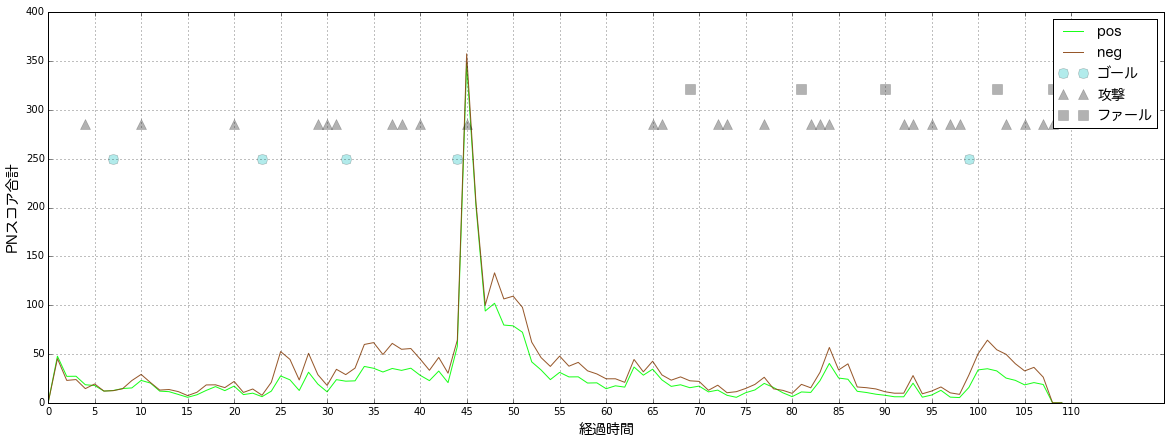

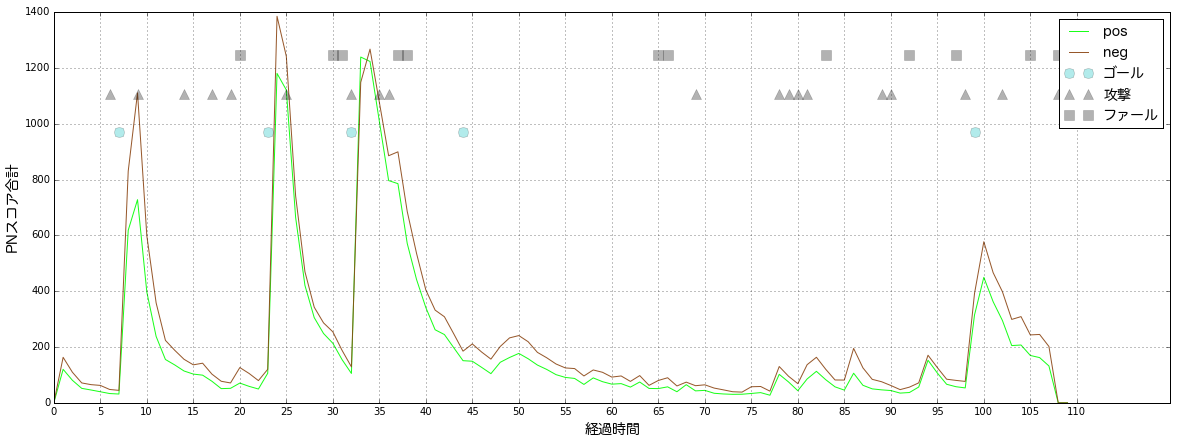

In [14]:
my_plot.PlotLineChart(
    my_list_list=[nb_pos_list_home, nb_neg_list_home],
    labels=['pos', 'neg'],
    colors=['lime', 'saddlebrown'],
    title="Moview Reviews Naive Bayes Classifier: [Home]",
    xlabel=u"経過時間",
    ylabel=u"PNスコア合計",
    x_interval=5,
    width=20, height=7,
    grid=True,
    points=[goals_dic, attacks_dic_home, fouls_dic_home],
)

my_plot.PlotLineChart(
    my_list_list=[nb_pos_list_away, nb_neg_list_away],
    labels=['pos', 'neg'],
    colors=['lime', 'saddlebrown'],
    title="Moview Reviews Naive Bayes Classifier: [Away]",
    xlabel=u"経過時間",
    ylabel=u"PNスコア合計",
    x_interval=5,
    width=20, height=7,
    grid=True,
    points=[goals_dic, attacks_dic_away, fouls_dic_away],
)